In [1]:
#Python packages
import numpy as np
import pandas as pd
import re
from scipy import stats


#Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv', index_col=0)

In [3]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,...,year,dayofweek,weekofyear,dayofyear,quarter,is_month_start,Phase_Of_Day,time_by_phase_type,phase_of_day,practice_sec
0,27253bdc,45bb1e1b6b50c07b,2019-09-06 17:53:46.937000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,...,2019,4,36,249,3,0.0,Evening,0.00,Evening,47804.47
1,27253bdc,17eeb7f223665f53,2019-09-06 17:54:17.519000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,...,2019,4,36,249,3,0.0,Evening,0.00,Evening,47804.47
2,77261ab5,0848ef14a8dc6892,2019-09-06 17:54:56.302000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,...,2019,4,36,249,3,0.0,Evening,203527.66,Evening,47804.47
3,b2dba42b,0848ef14a8dc6892,2019-09-06 17:54:56.387000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,...,2019,4,36,249,3,0.0,Evening,203527.66,Evening,47804.47
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06 17:55:03.253000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,...,2019,4,36,249,3,0.0,Evening,203527.66,Evening,47804.47


### Feature Engineering

#### feature counting the number of assessments and games played per user

In [18]:
count = train.groupby(['installation_id','type'])['type'].count()
count = pd.DataFrame(count)
count.rename({'type':'type_count'},axis=1, inplace=True)
count.reset_index(inplace=True)

In [19]:
count.loc[(count['type']=='Assessment') & (count['type_count']<100), 'assessment_prac'] = 1
count.loc[(count['type']=='Assessment') & (count['type_count']>=100) & (count['type_count']<500), 'assessment_prac'] = 2
count.loc[(count['type']=='Assessment') & (count['type_count']>=500) & (count['type_count']<1000), 'assessment_prac'] = 3
count.loc[(count['type']=='Assessment') & (count['type_count']>=1000), 'assessment_prac'] = 4

In [20]:
count.loc[(count['type']=='Game') & (count['type_count']<100), 'game_prac'] = 1
count.loc[(count['type']=='Game') & (count['type_count']>=100) & (count['type_count']<500), 'game_prac'] = 2
count.loc[(count['type']=='Game') & (count['type_count']>=500) & (count['type_count']<1000), 'game_prac'] = 3
count.loc[(count['type']=='Game') & (count['type_count']>=1000) & (count['type_count']<8000), 'game_prac'] = 4
count.loc[(count['type']=='Game') & (count['type_count']>=8000), 'game_prac'] = 5

In [6]:
temp = train.copy()

In [7]:
cols = ['installation_id', 'type']
temp = temp.join(count.set_index(cols), on=cols, lsuffix='temp_', rsuffix='group_')

In [8]:
train['assessment_prac'] = temp['assessment_prac']
train['game_prac'] = temp['game_prac']

#### feature depicting game/assessment difficulty

In [9]:
train.groupby('title')['game_time'].agg(np.mean)
###depending on average game_time can make a feature depicting difficulty

title
12 Monkeys                            0.000000
Air Show                         179259.164832
All Star Sorting                 216088.487906
Balancing Act                         0.000000
Bird Measurer (Assessment)        90174.767762
Bottle Filler (Activity)         354691.892381
Bubble Bath                      252243.488859
Bug Measurer (Activity)          126066.392383
Cart Balancer (Assessment)        44935.744695
Cauldron Filler (Assessment)      61322.941606
Chest Sorter (Assessment)         59035.508904
Chicken Balancer (Activity)      147369.875760
Chow Time                        266010.943418
Costume Box                           0.000000
Crystal Caves - Level 1               0.000000
Crystal Caves - Level 2               0.000000
Crystal Caves - Level 3               0.000000
Crystals Rule                    238294.839778
Dino Dive                        194701.451205
Dino Drink                       194815.691968
Egg Dropper (Activity)           167486.742383
Firewor

#### Multiple features regarding frequency of play

In [10]:
games = train.groupby(['installation_id','month'])['game_session'].count()
games = pd.DataFrame(games)
games.reset_index(inplace=True)

In [12]:
###total time played
for i in games['installation_id'].unique():
    games.loc[games['installation_id']==i, 'total']=games[games['installation_id']==i]['game_session'].sum()

###mean time played
for i in games['installation_id'].unique():
    games.loc[games['installation_id']==i, 'average']=games[games['installation_id']==i]['game_session'].mean()
        
#number of months played per user
c=1
a=[]

for i in range(len(games)-1):
    if games['installation_id'][i]==games['installation_id'][i+1]:
        a.append(int(c))
        c+=1
    else:
        a.append(int(c))
#         games['months_played'][i]=int(c)
        c=1
    
for i in range(len(a)-1):
    if a[i+1]>1:
        a[i]=a[i+1]

a=pd.Series(a)
games['months_played']=a

##ratio of month session to total session
games['recent_ratio'] = games['game_session']/games['total']
for i in range(len(games)-1):
    if games['installation_id'][i]==games['installation_id'][i+1]:
        games['recent_ratio'][i]=-999
    else:
        games['recent_ratio'][i] = games['game_session'][i]/games['total'][i]
        
##feature determining whether or not a user has taken at least one assessment
train.loc[train['assessment_prac']==-999, 'assess_profile'] = 0
train.loc[train['assessment_prac']!=-999, 'assess_profile'] = 1

#adjusting for how soon before the final assessment was before first studying

games.loc[(games['recent_ratio']==1.000) & (games['months_played']==1.0) & (games['month']==7), 'recent_ratio']=.25
games.loc[(games['recent_ratio']==1.000) & (games['months_played']==1.0) & (games['month']==8), 'recent_ratio']=.50
games.loc[(games['recent_ratio']==1.000) & (games['months_played']==1.0) & (games['month']==9), 'recent_ratio']=.70
games.loc[(games['recent_ratio']==1.000) & (games['months_played']==1.0) & (games['month']==10), 'recent_ratio']=.90

##if played more than one month, recent_raio should be rewarded because of consistency over time

games.loc[games['months_played']==2.0, 'recent_ratio'] = games['recent_ratio']*1.25
games.loc[games['months_played']==3.0, 'recent_ratio'] = games['recent_ratio']*1.5
games.loc[games['recent_ratio']>=1.0, 'recent_ratio'] = games['recent_ratio']*1.5

In [19]:
games.loc[games['recent_ratio']<0, 'recent_ratio'] = -999

In [21]:
temp = train.copy()
cols = ['installation_id', 'month']
temp = temp.join(games.set_index(cols), on=cols, lsuffix='temp_', rsuffix='group_')
train['months_played'] = temp['months_played']
train['recent_ratio'] = temp['recent_ratio']
train['total'] = temp['total']

In [23]:
cols = ['assessment_prac', 'game_prac']
for col in train[cols]:
    train[col].fillna(-999, inplace=True)

In [25]:
train.rename({'total':'total_game_time'}, axis=1, inplace=True)

### Outlier Removal

#### Removing extremely large values of game_time per each game title

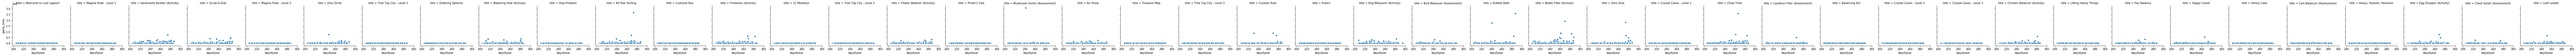

In [27]:
g = sns.FacetGrid(train, col='title')
g = g.map(plt.scatter, "dayofyear", "game_time", edgecolor="w")

In [46]:
'''Based on the charts above, we will remove all values above 40 mil and replace it for 
the game_time mean of each respective title'''

train.loc[(train['title']=='Dino Drink') &
          (train['game_time']>40000000),
          'game_time']=train.loc[train['title']=='Dino Drink']['game_time'].mean()
train.loc[(train['title']=='Sandcastle Builder (Activity)') &
          (train['game_time']>40000000),
          'game_time']=train.loc[train['title']=='Sandcastle Builder (Activity)']['game_time'].mean()
train.loc[(train['title']=='All Star Sorting') &
          (train['game_time']>40000000),
          'game_time']=train.loc[train['title']=='All Star Sorting']['game_time'].mean()
train.loc[(train['title']=='Fireworks (Activity)') &
          (train['game_time']>50000000),
          'game_time']=train.loc[train['title']=='Fireworks (Activity)']['game_time'].mean()
train.loc[(train['title']=='Mushroom Sorter (Assessment)') &
          (train['game_time']>50000000),
          'game_time']=train.loc[train['title']=='Mushroom Sorter (Assessment)']['game_time'].mean()
train.loc[(train['title']=='Crystals Rule') &
          (train['game_time']>40000000),
          'game_time']=train.loc[train['title']=='Crystals Rule']['game_time'].mean()
train.loc[(train['title']=='Bubble Bath') &
          (train['game_time']>40000000),
          'game_time']=train.loc[train['title']=='Bubble Bath']['game_time'].mean()
train.loc[(train['title']=='Bottle Filler (Activity)') &
          (train['game_time']>50000000),
          'game_time']=train.loc[train['title']=='Bottle Filler (Activity)']['game_time'].mean()
train.loc[(train['title']=='Dino Dive') &
          (train['game_time']>40000000),
          'game_time']=train.loc[train['title']=='Dino Dive']['game_time'].mean()
train.loc[(train['title']=='Chow Time') &
          (train['game_time']>40000000),
          'game_time']=train.loc[train['title']=='Chow Time']['game_time'].mean()
train.loc[(train['title']=='Cauldron Filler (Assessment)') &
          (train['game_time']>40000000),
          'game_time']=train.loc[train['title']=='Cauldron Filler (Assessment)']['game_time'].mean()
train.loc[(train['title']=='Chicken Balancer (Activity)') &
          (train['game_time']>50000000),
          'game_time']=train.loc[train['title']=='Chicken Balancer (Activity)']['game_time'].mean()
train.loc[(train['title']=='Happy Camel') &
          (train['game_time']>40000000),
          'game_time']=train.loc[train['title']=='Happy Camel']['game_time'].mean()
train.loc[(train['title']=='Egg Dropper (Activity)') &
          (train['game_time']>40000000),
          'game_time']=train.loc[train['title']=='Egg Dropper (Activity)']['game_time'].mean()
train.loc[(train['title']=='Leaf Leader') &
          (train['game_time']>40000000),
          'game_time']=train.loc[train['title']=='Leaf Leader']['game_time'].mean()

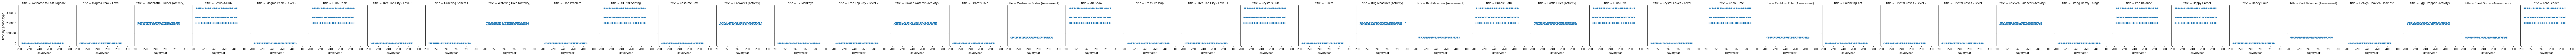

In [48]:
g = sns.FacetGrid(train, col='title')
g = g.map(plt.scatter, "dayofyear", "time_by_phase_type", edgecolor="w")

In [49]:
####we will determine difficulty by type(Assessment being high difficulty, clip lowest) and by Level (eg. Level 1)

train.loc[(train['title'].str.contains('Assessment')) | (train['title'].str.contains('Level 3')) | (train['type']=='Assessment'), 'difficulty'] = 3
train.loc[(train['type']=='Game') | (train['title'].str.contains('Level 2')), 'difficulty'] = 2
train.loc[(train['type']=='Activity') | (train['title'].str.contains('Activity')), 'difficulty'] = 1
train.loc[train['type']=='Clip', 'difficulty'] = 0

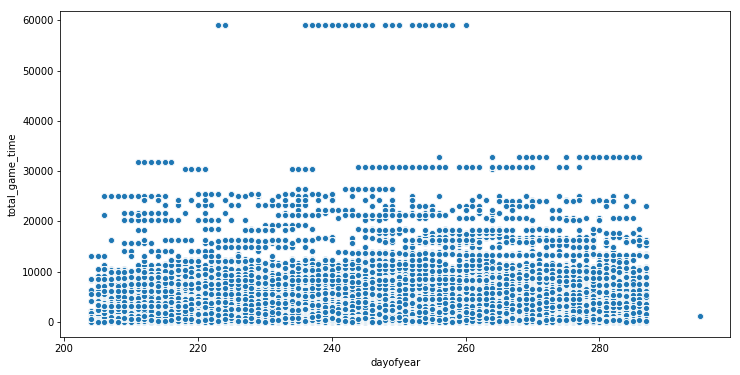

In [54]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='dayofyear', y='total_game_time', data=train)

In [62]:
'''Removing 'total_game_time' that exceeds 40000 since less than 0% of the data have game
time above this number
'''
print('Percent game time above 40,000:' + str(len(train.loc[train['total_game_time']>40000])/train.shape[0]))

train.loc[train['total_game_time']>40000, 'total_game_time'] = (train['total_game_time'].mean())*1.25

Percent game time above 40,000:0.0


In [68]:
train.to_csv('train.csv')